In [3]:
import csv
import os
import re
import requests
from packaging import version
from google.colab import userdata


In [4]:
INPUT_CSV = "merged_commits_11-11-2025_12-57-06.csv"
OUTPUT_CSV = "commits_corrigem_vulnerabilidade.csv"

TOKEN = userdata.get('GITHUB_TOKEN')
if not TOKEN:
    raise Exception("Defina a variável de ambiente GITHUB_TOKEN")

headers = {
    "Accept": "application/vnd.github.v3+json",
    "Authorization": f"token {TOKEN}"
}

In [ ]:
# @title
# ------------------------------------------------------------
# VERSÕES VULNERÁVEIS
# ------------------------------------------------------------

vuln_ranges = [
    (version.Version("3.3.0"), version.Version("4.13.1")),
    (version.Version("2.0.0"), version.Version("7.0.0")),
    (version.Version("1.5.0"), version.Version("1.5.2")),
]

def is_vulnerable(ver_str):
    try:
        v = version.Version(ver_str)
    except:
        return False
    for low, high in vuln_ranges:
        if v >= low and v < high:
            return True
    return False

version_regex = r"node-sass[^0-9]*([0-9]+\.[0-9]+\.[0-9]+)"

def extract_versions(line):
    return re.findall(version_regex, line)

# ------------------------------------------------------------
# DOWNLOAD DO PATCH
# ------------------------------------------------------------

def fetch_commit_patch(commit_url):
    api_url = commit_url.replace("github.com", "api.github.com/repos").replace("/commit/", "/commits/")

    r = requests.get(api_url, headers=headers)
    if r.status_code != 200:
        print("Erro ao baixar commit:", r.status_code, commit_url)
        return None

    data = r.json()
    patches = []

    for file in data.get("files", []):
        if file.get("filename") in ["package.json", "package-lock.json", "yarn.lock"]:
            if "patch" in file:
                patches.append(file["patch"])

    return "\n".join(patches)

# ------------------------------------------------------------
# PROCESSAMENTO
# ------------------------------------------------------------

results = []

with open(INPUT_CSV, newline='', encoding="utf-8") as f:
    reader = csv.DictReader(f)

    for row in reader:
        commit_url = row["url"]
        commit_sha = row["sha"]

        print("Analisando commit:", commit_sha)

        patch = fetch_commit_patch(commit_url)
        if not patch:
            continue

        old_versions = []
        new_versions = []

        for line in patch.split("\n"):
            if line.startswith("-") and "node-sass" in line:
                old_versions.extend(extract_versions(line))
            if line.startswith("+") and "node-sass" in line:
                new_versions.extend(extract_versions(line))

        replaced_by_sass = any(
            line.startswith("+") and ("\"sass\"" in line or "dart-sass" in line)
            for line in patch.split("\n")
        )

        if not old_versions and not new_versions and not replaced_by_sass:
            continue

        vulnerable_before = any(is_vulnerable(v) for v in old_versions)
        secure_after = any(not is_vulnerable(v) for v in new_versions)
        removed_dependency = old_versions and not new_versions

        # ------------------------------------------------------------
        # UPGRADE detection
        # ------------------------------------------------------------
        is_upgrade = False
        if old_versions and new_versions:
            try:
                old_v = version.Version(old_versions[0])
                new_v = version.Version(new_versions[0])
                is_upgrade = new_v > old_v
            except:
                pass

        # ------------------------------------------------------------
        # CLASSIFICAÇÃO FINAL
        # ------------------------------------------------------------

        if vulnerable_before and (secure_after or removed_dependency or replaced_by_sass):
            status = "corrige vulnerabilidade"

        elif removed_dependency:
            status = "remoção"

        elif replaced_by_sass:
            status = "substituição"

        elif is_upgrade:
            status = "upgrade"

        else:
            status = "outras abordagens"

        # ------------------------------------------------------------
        # RESULTADOS
        # ------------------------------------------------------------

        row["old_version"] = ", ".join(old_versions) if old_versions else ""
        if new_versions:
            row["new_version"] = ", ".join(new_versions)
        elif removed_dependency:
            row["new_version"] = "removed"
        elif replaced_by_sass:
            row["new_version"] = "sass/dart-sass"
        else:
            row["new_version"] = ""

        row["status"] = status
        results.append(row)


# ------------------------------------------------------------
# SAVE CSV
# ------------------------------------------------------------

with open(OUTPUT_CSV, "w", newline='', encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("\n✓ Classificação concluída!")
print(f"✓ {len(results)} commits analisados")
print(f"✓ Arquivo salvo em: {OUTPUT_CSV}")

Analisando commit: 3f5011a0e8f2dd4f260c7d3474215460d9c90548
Analisando commit: 0203997f12d501c5437c481733254871c40e9b83
Analisando commit: e1bcc7404a95aca0a3ffec68642107e325d27edc
Analisando commit: ac55ae96cd917c09190c212ab2cb060a3b317826
Analisando commit: c248d503b5aef0e66ec6cc2fdeb3d4712b2bd8b9
Erro ao baixar commit: 404 https://github.com/enara28/enara_itzala/commit/c248d503b5aef0e66ec6cc2fdeb3d4712b2bd8b9
Analisando commit: e2e0c0e7986a4da30957703701e1d9ed2109e647
Analisando commit: 271e3f6f4361125c6365492adf54613ac7bc7b63
Analisando commit: dede37cbdf6a48cf18e6e3a21200155e728189a6
Analisando commit: 07df67cde8b12d43a61c70cde024870143d0f331
Analisando commit: 818916160bb8e4d8b908efa38cb9a8f1cc651bd4
Analisando commit: fc5a3ef776811b137d59658a682f3e135c3637b1
Analisando commit: 66408c9ede21815d7aa11b322de9940a020a5f68
Analisando commit: e7793ec157c5e13bb4cc4538d3f069f695db26d5
Analisando commit: 58d64babbf62c5aa940e594bce8d7c5454e93f9c
Analisando commit: eb7e094722fedfe0cc4c095bac

#Gráficos estatísticos


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from wordcloud import WordCloud
import networkx as nx

#SETUP

In [5]:
# ================================
# 1) LOAD CSV
# ================================
df = pd.read_csv(OUTPUT_CSV)

# Converte data para datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)

# Remove datas inválidas
df = df[df["date"].notna()].copy()

# Categorias padrão
CATEGORIES = [
    "corrige vulnerabilidade",
    "remoção",
    "substituição",
    "upgrade",
    "outras abordagens"
]

# Paleta padrão
PALETTE = sns.color_palette("Set2", len(CATEGORIES))
COLOR_MAP = dict(zip(CATEGORIES, PALETTE))

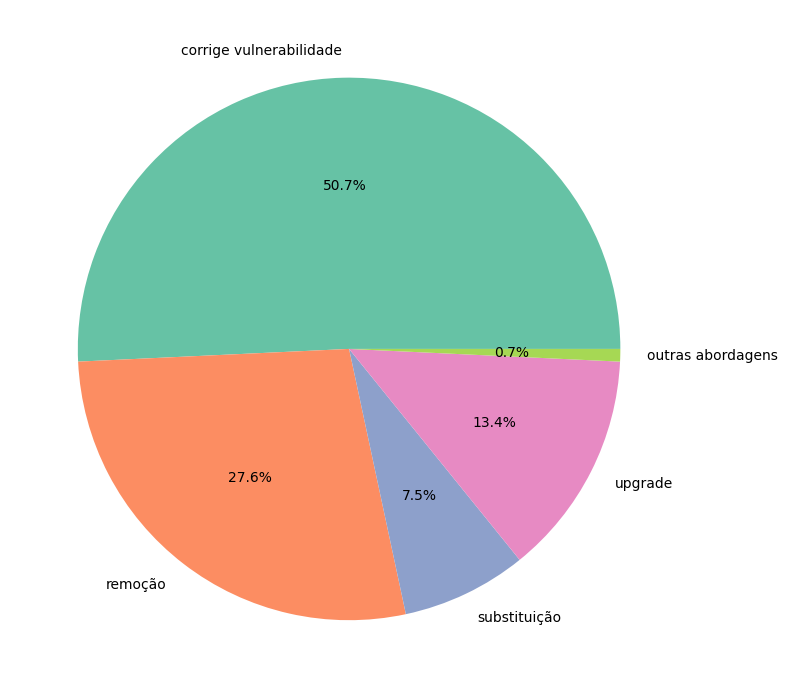

In [ ]:
# ================================
# 2) DISTRIBUIÇÃO DE CATEGORIAS
# ================================

# Pie chart
plt.figure(figsize=(8, 8))
df["status"].value_counts()[CATEGORIES].plot(
    kind="pie", autopct='%1.1f%%', colors=PALETTE
)
# plt.title("Proporção das Categorias de Ação")
plt.ylabel("")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4180932353.py:4: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



<Figure size 1200x600 with 0 Axes>

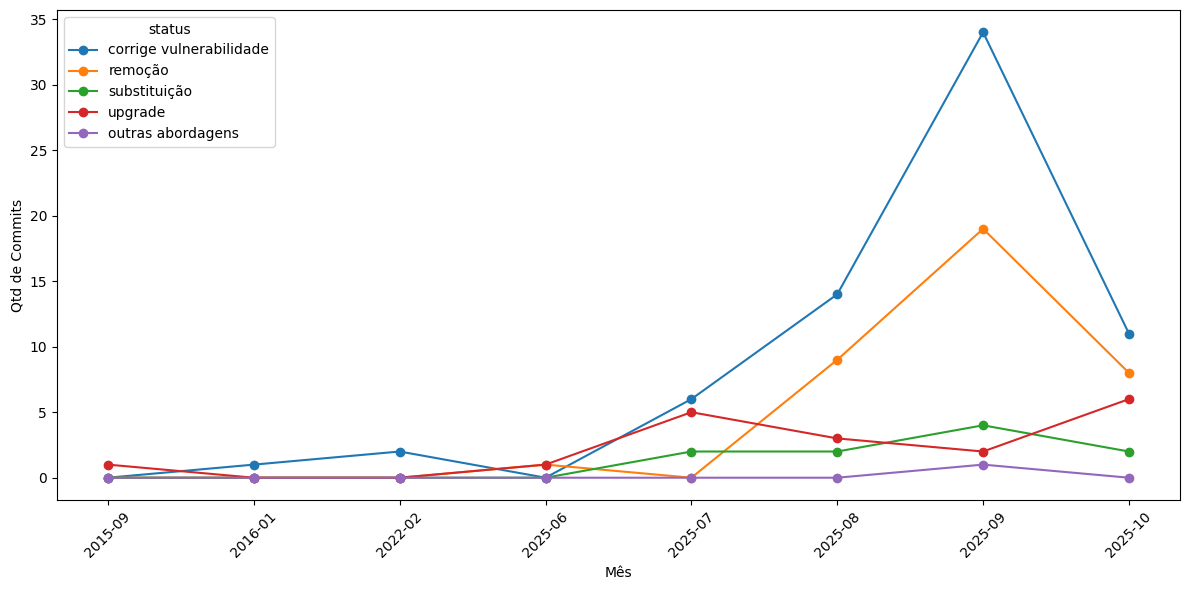

In [ ]:
# ================================
# 3) EVOLUÇÃO TEMPORAL
# ================================
df["year_month"] = df["date"].dt.to_period("M").astype(str)

plt.figure(figsize=(12, 6))
pivot = df.groupby(["year_month", "status"]).size().unstack().fillna(0)
pivot[CATEGORIES].plot(kind="line", marker="o", figsize=(12, 6))
# plt.title("Evolução Temporal das Ações")
plt.xlabel("Mês")
plt.ylabel("Qtd de Commits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3887016427.py:23: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



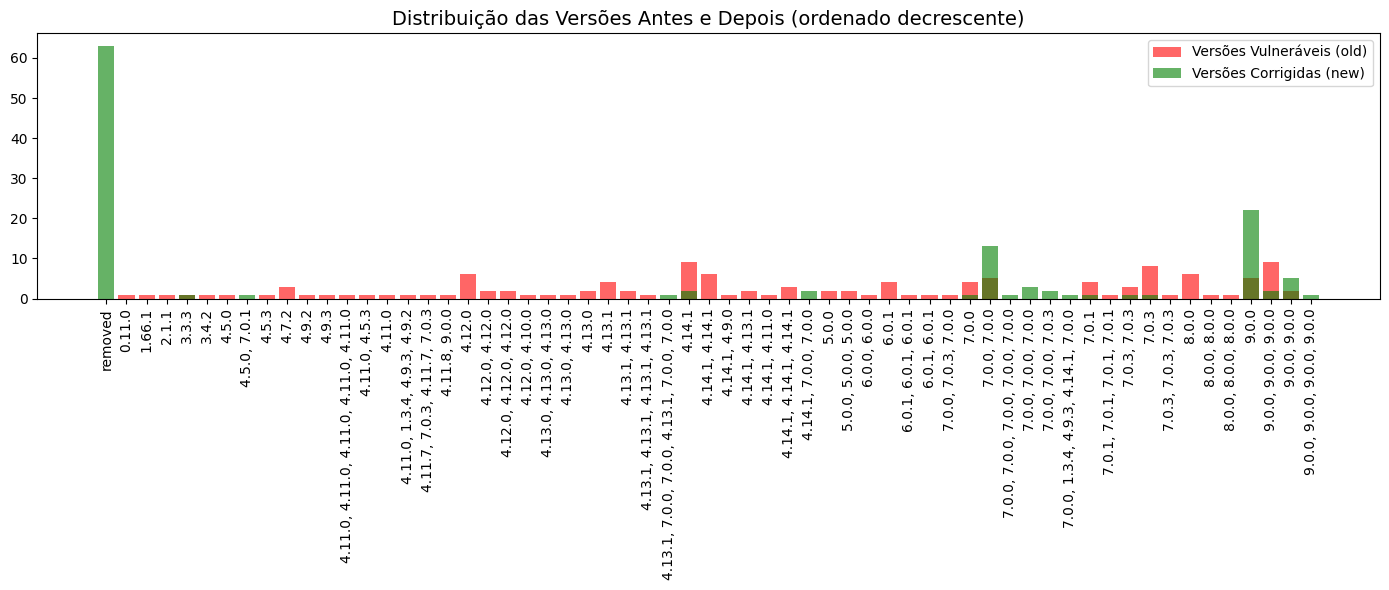

In [ ]:
import re
import numpy as np

# Função para converter "1.2.3" → (1, 2, 3)
def version_tuple(v):
    if not isinstance(v, str):
        return ()
    nums = re.findall(r"\d+", v)
    if len(nums) == 0:
        return ()
    nums = list(map(int, nums))
    while len(nums) < 3:
        nums.append(0)
    return tuple(nums[:3])

ver_df = df.dropna(subset=["old_version", "new_version"]).copy()

# Converter para tuplas ordenáveis
ver_df["old_tuple"] = ver_df["old_version"].apply(version_tuple)
ver_df["new_tuple"] = ver_df["new_version"].apply(version_tuple)

# Coletar lista única de versões ordenadas DESC
all_versions = pd.unique(
    list(ver_df["old_version"]) + list(ver_df["new_version"])
)

# Criar ordem decrescente
ordered_versions = sorted(
    all_versions,
    key=lambda v: version_tuple(v),
    # reverse=True
)

# Agora construir contagens manuais
old_counts = ver_df["old_version"].value_counts().reindex(ordered_versions, fill_value=0)
new_counts = ver_df["new_version"].value_counts().reindex(ordered_versions, fill_value=0)

# ================================
# GRÁFICO FINAL ORDENADO
# ================================
plt.figure(figsize=(14, 6))
plt.bar(ordered_versions, old_counts, color="red", alpha=0.6, label="Versões Vulneráveis (old)")
plt.bar(ordered_versions, new_counts, color="green", alpha=0.6, label="Versões Corrigidas (new)")

plt.title("Distribuição das Versões Antes e Depois (ordenado decrescente)", fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


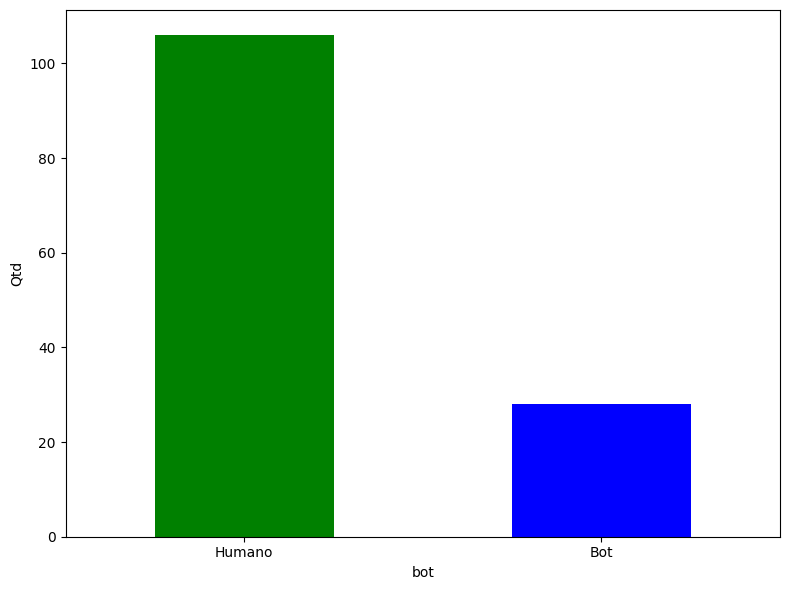

In [ ]:
# ================================
# 10) BOTS VS HUMANOS
# ================================
df["bot"] = df["author"].fillna("").str.contains("bot", case=False)

plt.figure(figsize=(8, 6))
df["bot"].value_counts().plot(kind="bar", color=["green", "blue"])
# plt.title("Commits por Bot vs Humanos")
plt.xticks([0, 1], ["Humano", "Bot"], rotation=0)
plt.ylabel("Qtd")
plt.tight_layout()
plt.show()

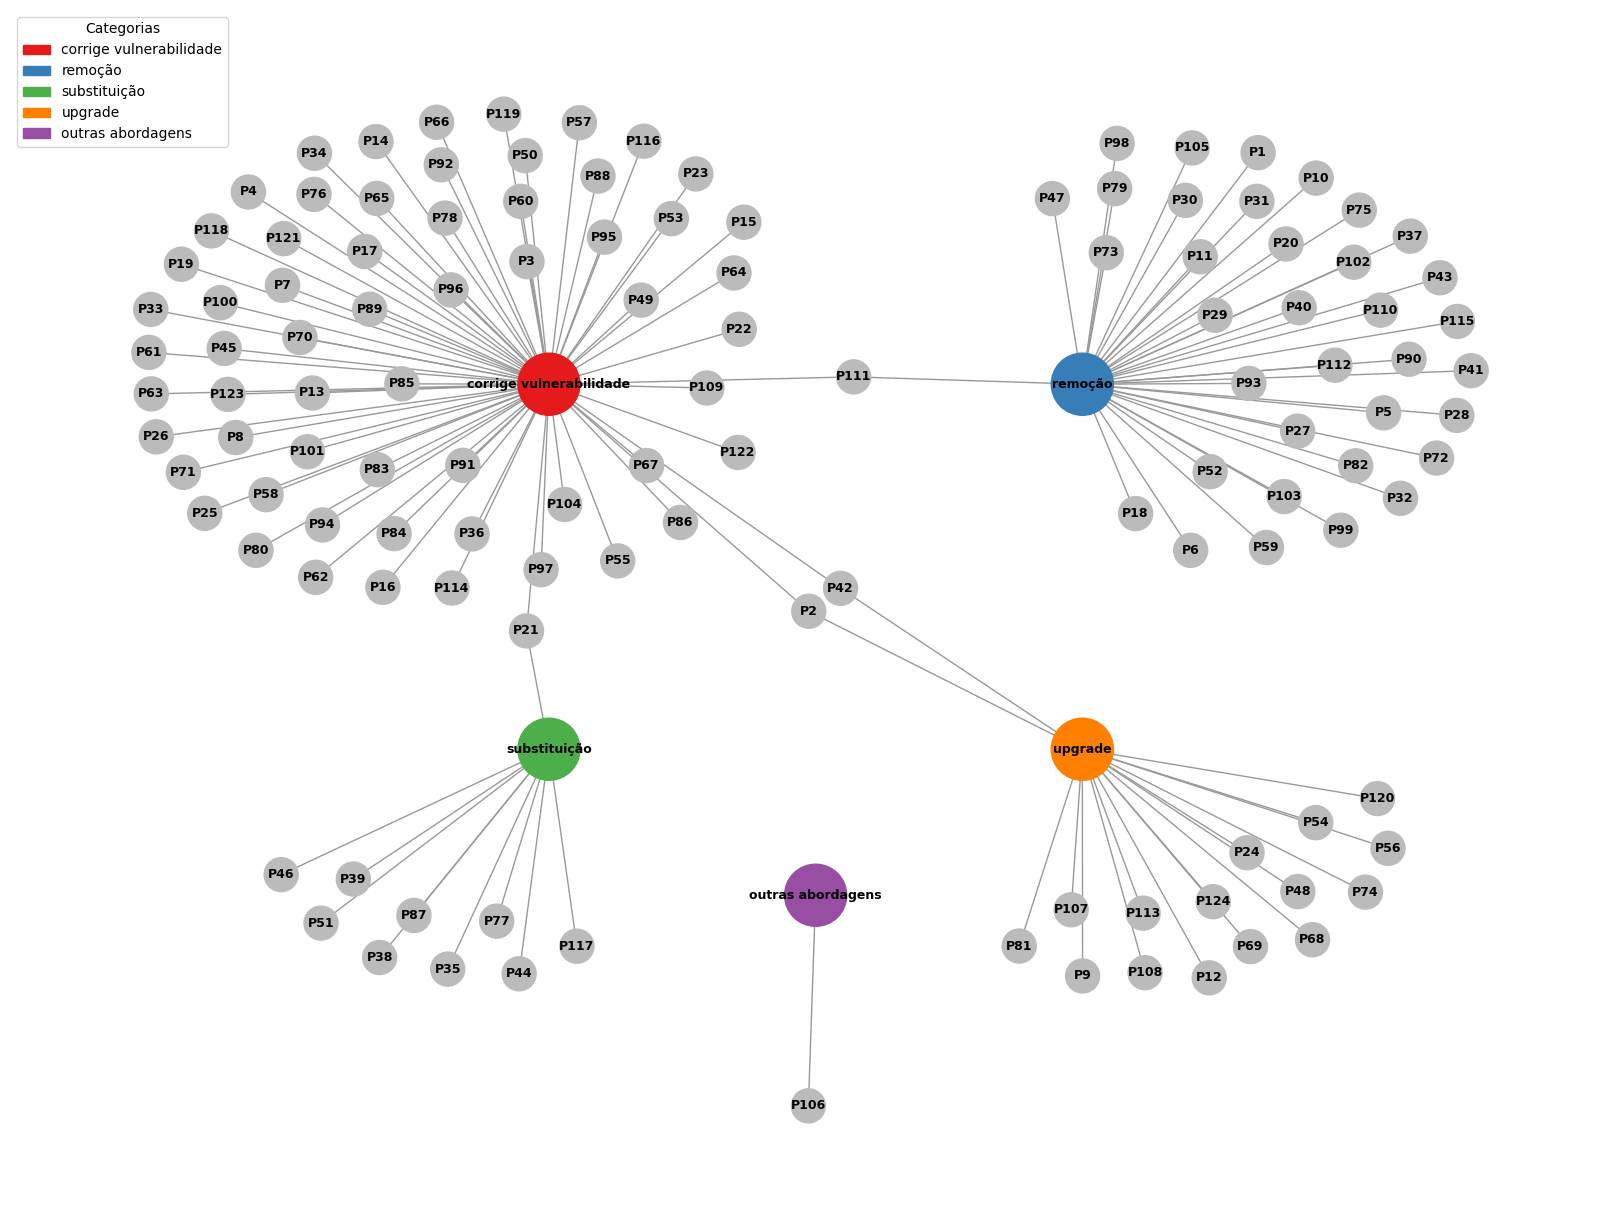

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Mapeia projetos para P1..PN
# ================================
unique_projects = df["repo"].unique()
project_map = {proj: f"P{i+1}" for i, proj in enumerate(unique_projects)}
df["project_alias"] = df["repo"].map(project_map)

# ================================
# Criar grafo
# ================================
G = nx.Graph()

for _, row in df.iterrows():
    G.add_edge(row["project_alias"], row["status"])

# ================================
# Cores das categorias
# ================================
CATEGORY_COLORS = {
    "corrige vulnerabilidade": "#e41a1c",  # vermelho
    "remoção": "#377eb8",                  # azul
    "substituição": "#4daf4a",             # verde
    "upgrade": "#ff7f00",                  # laranja
    "outras abordagens": "#984ea3"         # roxo
}

# ================================
# 1) Fixar posições das categorias nos cantos
# ================================
fixed_positions = {
    "corrige vulnerabilidade": (-1,  1),
    "remoção":                 ( 1,  1),
    "substituição":            (-1, -1),
    "upgrade":                 ( 1, -1),
    "outras abordagens":       ( 0, -1.8),  # pode mudar lugar
}

fixed_nodes = list(fixed_positions.keys())

# ================================
# 2) Gerar layout para todos os nós,
#    mantendo as categorias fixas
# ================================
pos = nx.spring_layout(
    G,
    k=0.35,
    seed=42,
    pos=fixed_positions,      # passa as posições fixas
    fixed=fixed_nodes         # mantém fixas
)

# ================================
# 3) Configurar cores e tamanhos
# ================================
node_colors = [
    CATEGORY_COLORS[n] if n in CATEGORY_COLORS else "#bbbbbb"
    for n in G.nodes()
]

node_sizes = [
    2000 if n in CATEGORY_COLORS else 600
    for n in G.nodes()
]

# ================================
# 4) Desenhar grafo
# ================================
plt.figure(figsize=(16, 12))

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    edge_color="#999999",
    font_size=9,
    font_weight="bold"
)

# plt.title("Grafo: Projetos (P1..PN) ↔ Categorias (posicionadas nos cantos)", fontsize=16)

# Legenda
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color, label=cat) for cat, color in CATEGORY_COLORS.items()]
plt.legend(handles=handles, title="Categorias", loc="upper left")

plt.show()


In [7]:
import pandas as pd
import plotly.graph_objects as go

# Filtrar somente commits com ambas versões
flow_df = df.dropna(subset=["old_version", "new_version"]).copy()

# ===============================================
# Normalização das versões sass/dart-sass
# ===============================================
def normalize_version(v):
    if not isinstance(v, str):
        return v
    v = v.strip().lower()
    if "dart" in v:
        return "dart-sass"
    if v.startswith("sass"):
        return "sass"
    return v

flow_df["old_version"] = flow_df["old_version"].apply(normalize_version)
flow_df["new_version"] = flow_df["new_version"].apply(normalize_version)

# ===============================================
# LISTA DE NÓS DO SANKEY
# ===============================================
nodes = pd.unique(flow_df[["old_version", "new_version"]].values.ravel())
node_index = {node: i for i, node in enumerate(nodes)}

# ===============================================
# Definir cores com base na categoria (status)
# ===============================================
COLOR_BY_STATUS = {
    "remoção": "rgba(220,20,60,0.6)",                   # red
    "substituição": "rgba(50,205,50,0.6)",              # green
    "upgrade": "rgba(255,140,0,0.6)",                   # orange
    "corrige vulnerabilidade": "rgba(30,144,255,0.6)",  # blue
    "outras abordagens": "rgba(138,43,226,0.6)"         # purple
}

# ===============================================
# Criar fluxos (source, target, value, color)
# ===============================================
sources = []
targets = []
values = []
colors = []

for _, row in flow_df.iterrows():
    src = node_index[row["old_version"]]
    tgt = node_index[row["new_version"]]

    sources.append(src)
    targets.append(tgt)
    values.append(1)

    # cor pela categoria
    status = row["status"]
    colors.append(COLOR_BY_STATUS.get(status, "rgba(0,0,0,0.4)"))

# ===============================================
# Criar figura Sankey
# ===============================================
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=25,
        thickness=20,
        line=dict(color="black", width=0.8),
        label=list(nodes),
        color="rgba(200,200,200,0.7)"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=colors
    )
)])

fig.update_layout(
    # title_text="Fluxo de Migração de Versões",
    font_size=12,
    width=1400,
    height=900
)

fig.show()
